In [10]:
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

### Introduction

In this project, I will use a multiple linear regression model to generate a signal for SPY. SPY tracks the SPDR S&P 500 ETF trust, an exchange-traded fund which trades on the NYSE Arca, and is the largest and oldest ETF in the world. We will use multiple indices from the global markets to predict the daily price change in SPY. These indices include aud ordinaries from Australia, Nikkei from Japan, HSI from HK, DAX from Germany, CAC40 from France, S&P 500, Dji, and Nasdaq from US market.

### Data Preparation

We first import all the market indicies and SPY data.

In [22]:
# Import stock market data into DataFrames
aord = pd.read_csv('./data/ALLOrdinary.csv', index_col=0)
nikkei = pd.read_csv('./data/Nikkei225.csv', index_col=0)
hsi = pd.read_csv('./data/HSI.csv', index_col=0)
daxi = pd.read_csv('./data/DAXI.csv', index_col=0)
cac40 = pd.read_csv('./data/CAC40.csv', index_col=0)
sp500 = pd.read_csv('./data/SP500.csv', index_col=0)
dji = pd.read_csv('./data/DJI.csv', index_col=0)
nasdaq = pd.read_csv('./data/nasdaq_composite.csv', index_col=0)
spy = pd.read_csv('./data/SPY.csv', index_col=0)

Then we view some entries of these data.

In [23]:
aord.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-01-01,6418.600098,6462.799805,6408.399902,6434.100098,6434.100098,365493500.0
2008-01-02,6422.700195,6422.700195,6335.799805,6372.600098,6372.600098,511702600.0
2008-01-03,6387.700195,6421.200195,6355.000000,6385.399902,6385.399902,627840800.0
2008-01-06,6357.799805,6357.799805,6227.700195,6240.399902,6240.399902,692737000.0
2008-01-07,6233.200195,6259.700195,6195.299805,6205.700195,6205.700195,772191800.0


In [28]:
aord.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-08-15,6386.200195,6415.700195,6363.299805,6415.700195,6415.700195,827103100.0
2018-08-16,6415.700195,6416.500000,6369.799805,6412.600098,6412.600098,995114200.0
2018-08-17,6412.600098,6433.899902,6404.700195,6426.200195,6426.200195,790706800.0
2018-08-20,6425.799805,6447.299805,6425.799805,6435.100098,6435.100098,867087100.0
2018-08-21,6435.100098,6436.500000,6375.000000,6383.000000,6383.000000,701247000.0


The timespan of the dataset ranges from 2008-01-01 to 2018-08-21. 

Below shows a plot of the SPY open price.

Text(0.5, 1.0, 'SPY Open Price')

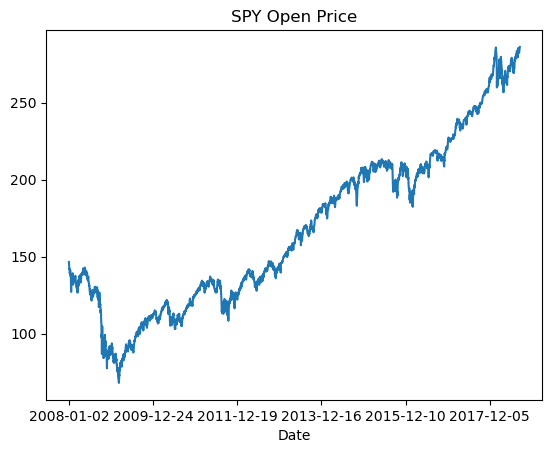

In [26]:
spy['Open'].plot()
plt.title('SPY Open Price')
plt.xlabel('Date')
plt.ylabel('')

Our response variable is the SPY open price on the next day - SPY open price on the current day. Our predictor variables contain 3 groups: open price on the current day - open price on the previous day for US market indices, open price on the current day - open price on the previous day for EU market indices, and close price on the current day - open price on the current day for Asian and Australian market indices. 

Due to the timezone difference in these regions, Asian and Austrialian market information on the current day is available for US maket, as these markets have closed before the US market opens. Hence the daily change in prices could be defined as close - open. The EU market information on the current day is not avaible, as it closes after the US market opens. Hence, we use the one-day lag information of the opening price, as the close price is not available then.

In [29]:
# Indicepanel is the DataFrame of our trading model
indicepanel=pd.DataFrame(index=spy.index)

indicepanel['spy']=spy['Open'].shift(-1)-spy['Open']
indicepanel['spy_lag1']=indicepanel['spy'].shift(1)
indicepanel['sp500']=sp500["Open"]-sp500['Open'].shift(1)
indicepanel['nasdaq']=nasdaq['Open']-nasdaq['Open'].shift(1)
indicepanel['dji']=dji['Open']-dji['Open'].shift(1)

indicepanel['cac40']=cac40['Open']-cac40['Open'].shift(1)
indicepanel['daxi']=daxi['Open']-daxi['Open'].shift(1)

indicepanel['aord']=aord['Close']-aord['Open']
indicepanel['hsi']=hsi['Close']-hsi['Open']
indicepanel['nikkei']=nikkei['Close']-nikkei['Open']
indicepanel['Price']=spy['Open']

In [30]:
indicepanel.head()

,spy,spy_lag1,sp500,nasdaq,dji,cac40,daxi,aord,hsi,nikkei,Price
Date,,,,,,,,,,,
2008-01-02,-1.619995,NaN,NaN,NaN,NaN,NaN,NaN,-50.100097,-71.679688,NaN,146.529999
2008-01-03,-1.570008,-1.619995,-20.419922,-41.949951,-217.70019,-71.779785,-104.450195,-2.300293,-162.750000,NaN,144.910004
2008-01-04,-1.529998,-1.570008,-3.540039,-40.879883,2.43945,5.489746,-27.990235,NaN,515.349609,-464.320313,143.339996
2008-01-07,0.270004,-1.529998,-29.940064,-56.930176,-245.40918,-111.689941,-102.709961,-27.500000,216.951171,-48.830078,141.809998
2008-01-08,-2.990006,0.270004,1.640015,-7.179931,19.75000,44.509766,33.680176,-33.899902,-354.060547,99.370117,142.080002


We could see that there are NaN values in the dataframe. So we need to remove them, then check if there is NaN value left, and save the processed dataframe.

In [31]:
# Forward fill the NaN values and drop NaN
indicepanel = indicepanel.fillna(method='ffill')
indicepanel = indicepanel.dropna()

In [32]:
# Check remaining NaN values 
indicepanel.isnull().sum()

spy         0
spy_lag1    0
sp500       0
nasdaq      0
dji         0
cac40       0
daxi        0
aord        0
hsi         0
nikkei      0
Price       0
dtype: int64

In [33]:
# Save the processed data
path_save = './data/indicepanel.csv'
indicepanel.to_csv(path_save)

### Data Splitting

We split the data into train and test sets, at a splitting ratio of 50:50.

In [34]:
print(indicepanel.shape)

(2677, 11)


In [36]:
# Split data into train and test sets.
Train = indicepanel.iloc[-2000:-1000, :]
Test = indicepanel.iloc[-1000:, :]

In [37]:
print(Train.shape, Test.shape)

(1000, 11) (1000, 11)


### Exploaratory Data Analysis

We produce pairwise scatter plots for each predictor variable.

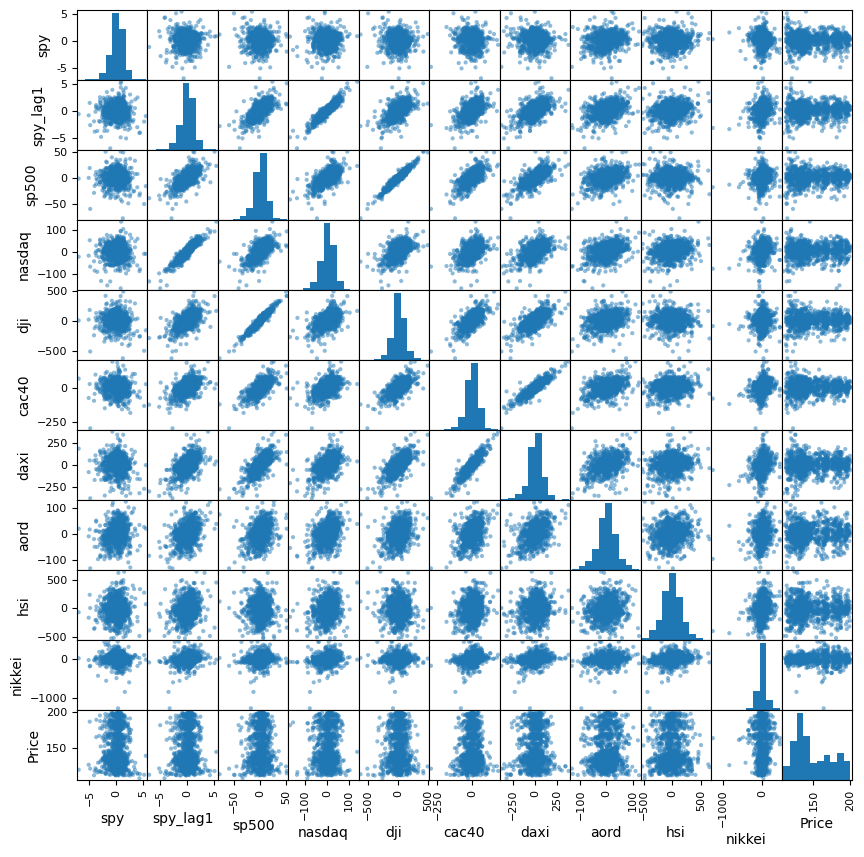

In [46]:
# Pairwise scatter plots: train set
sm = pd.plotting.scatter_matrix(Train, figsize=(10, 10))

The scatter plots between predictor variables mostly show no explicit correlation pattern, which is the evidence of highly noisy financial market data. However, some pairs do show positive correlation pattern which is nearly a straight line, like SP 50 and dji. 

We also want to check the correlation coefficient between each predictor variable and the response variable 'spy'.

In [50]:
# Find the indice with largest correlation: train set
corr_array = Train.iloc[:, :-1].corr()['spy']
print(corr_array)

spy         1.000000
spy_lag1   -0.011623
sp500      -0.018632
nasdaq      0.012333
dji        -0.037097
cac40      -0.055304
daxi       -0.069735
aord        0.179638
hsi         0.031400
nikkei     -0.035048
Name: spy, dtype: float64


We can see that the correlation between response variable and European/Asian market indices are higher than the correlation between response variable and US market indices.

### Multiple Linear Regression Model

In [52]:
formula = 'spy~spy_lag1+sp500+nasdaq+dji+cac40+aord+daxi+nikkei+hsi'
lm = smf.ols(formula=formula, data=Train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    spy   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     7.962
Date:                Sat, 19 Aug 2023   Prob (F-statistic):           1.97e-11
Time:                        17:13:26   Log-Likelihood:                -1617.7
No. Observations:                1000   AIC:                             3255.
Df Residuals:                     990   BIC:                             3305.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0836      0.039      2.138      0.033       0.007       0.160
spy_lag1      -0.1567      0.091     -1.730      0.084      -0.335       0.021
sp500          0.0221      0.014      1.621      0.105      -0.005       0.049
nasdaq         0.0040      0.004      1.066      0.287      -0.003       0.011
dji           -0.0018      0.001     -1.248      0.212      -0.005       0.001
cac40         -0.0003      0.002     -0.153      0.879      -0.004       0.004
aord           0.0093      0.001      7.492      0.000       0.007       0.012
daxi          -0.0025      0.001     -2.387      0.017      -0.005      -0.000
nikkei        -0.0004      0.000     -1.264      0.207      -0.001       0.000
hsi            0.0003      0.000      1.222      0.222      -0.000       0.001
==============================================================================
Omnibus:                       91.018   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              267.687
Skew:                          -0.450   Prob(JB):                     7.45e-59
Kurtosis:                       5.369   Cond. No.                         405.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

At significance level 5\%, p-value for F-statistics is $1.97e^{-11} < 0.05$, null hypothesis rejected, and the proposed model is better than naive intercept-only model.

At significance level 5\%, most of the individual predictor p-values are not significant, except the Aord variable. This may be due to multicollinearity between predictor variables, but it does not reduce predictive power.

We now want to predict SPY daily change using our mode.

In [71]:
# Predict using model on train and test sets.
Train['PredictedY'] = lm.predict(Train)
Test['PredictedY'] = lm.predict(Test)

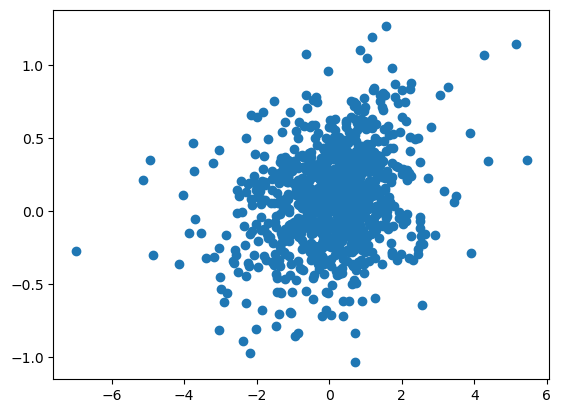

In [72]:
# Scatter plot between observed response and predicted response: train set
plt.scatter(Train['spy'], Train['PredictedY'])

The above scatter plot shows some positive correlation between the observed and predicted response variable. Since the response variable represents daily change, the extent of correlation is not too bad.

### Model Evaluation

We use Root Mean Squared Error and adjusted $R^2$ to measure the performance of the model.

RMSE is defined as $\frac{SSE}{n-k-1}$ measures the prediction error. It is the unbiased estimator of the variance of noise.

Adjusted $R^2$ is defined as $1 - \frac{(1-R^2)(n-1)}{n-k-1}$. It measures the percentage of variance explained by the model, compensated by the number of predictors.

In [73]:
# RMSE - Root Mean Squared Error, Adjusted R^2
def adjustedMetric(data, model, model_k, yname):
    data['yhat'] = model.predict(data)
    SST = ((data[yname] - data[yname].mean())**2).sum()
    SSR = ((data['yhat'] - data[yname].mean())**2).sum()
    SSE = ((data[yname] - data['yhat'])**2).sum()
    r2 = SSR/SST
    adjustR2 = 1 - (1-r2)*(data.shape[0] - 1)/(data.shape[0] -model_k -1)
    RMSE = (SSE/(data.shape[0] -model_k -1))**0.5
    return adjustR2, RMSE

In [74]:
def assessTable(test, train, model, model_k, yname):
    r2test, RMSEtest = adjustedMetric(test, model, model_k, yname)
    r2train, RMSEtrain = adjustedMetric(train, model, model_k, yname)
    assessment = pd.DataFrame(index=['R2', 'RMSE'], columns=['Train', 'Test'])
    assessment['Train'] = [r2train, RMSEtrain]
    assessment['Test'] = [r2test, RMSEtest]
    return assessment

In [75]:
# Get the assement table fo our model
assessTable(Test, Train, lm, 9, 'spy')

,Train,Test
R2,0.059020,0.067248
RMSE,1.226068,1.701291


RMSE for train set is slightly lower than RMSE for test set, but does not differ too much. The model is not overfitted. Adjusted $R^2$ is 5.9\% for train set and 6.7/% for test set, relatively low but not too bad for financial models.

### Signal Based Strategy

We propose a signal-based strategy based on the above multiple linear regression model, using the predicted daily price change of SPY as a signal. If the signal is positive, we long, otherwise, we short.

In [76]:
# Train
Train['Order'] = [1 if sig>0 else -1 for sig in Train['PredictedY']]
Train['Profit'] = Train['spy'] * Train['Order']

Train['Wealth'] = Train['Profit'].cumsum()
print('Total profit made in Train: ', Train['Profit'].sum())

Total profit made in Train:  214.34009500000042


In [77]:
# Test
Test['Order'] = [1 if sig>0 else -1 for sig in Test['PredictedY']]
Test['Profit'] = Test['spy'] * Test['Order']

Test['Wealth'] = Test['Profit'].cumsum()
print('Total profit made in Test: ', Test['Profit'].sum())

Total profit made in Test:  241.0300879999996


We also propose a passive buy and hold strategy as a comparison, and plot the performance of the two strategies on train and test sets.

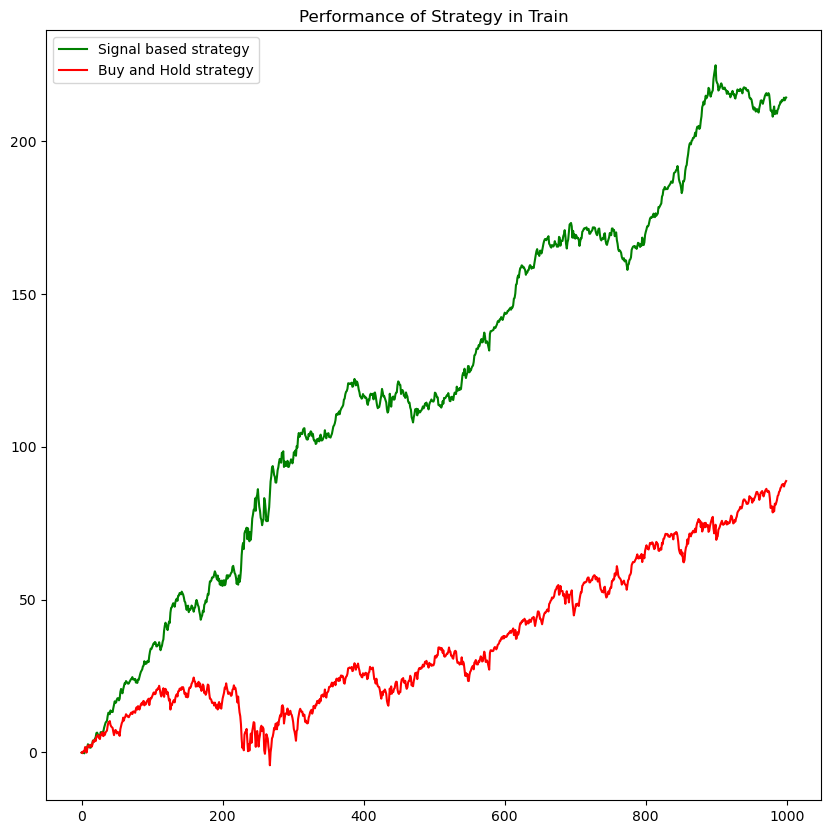

In [78]:
plt.figure(figsize=(10, 10))
plt.title('Performance of Strategy in Train')
plt.plot(Train['Wealth'].values, color='green', label='Signal based strategy')
plt.plot(Train['spy'].cumsum().values, color='red', label='Buy and Hold strategy')
plt.legend()
plt.show()

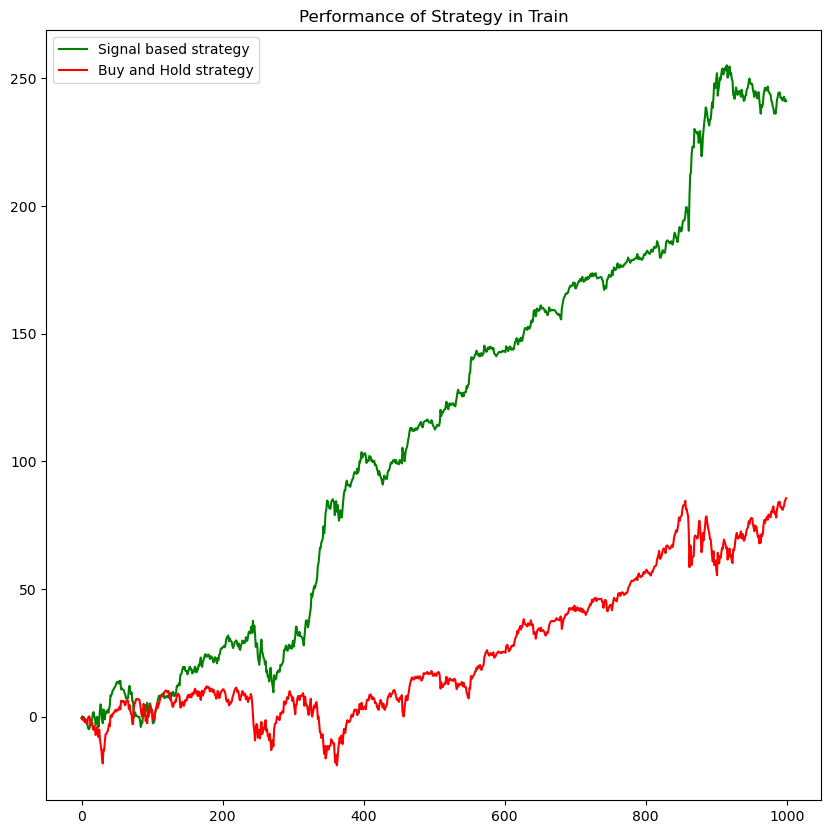

In [79]:
plt.figure(figsize=(10, 10))
plt.title('Performance of Strategy in Train')
plt.plot(Test['Wealth'].values, color='green', label='Signal based strategy')
plt.plot(Test['spy'].cumsum().values, color='red', label='Buy and Hold strategy')
plt.legend()
plt.show()

For both train and test sets, the signal-based strategy is profitable, making a total profit of \\$214 in train set, and \\$241 in test set. Comparing to the buy and hold strategy, the signal-based strategy shows a better performance.

### Strategy Evaluation

We use Sharpe ratio and maximum drawdown to evaluate the consistency of the strategy performance.

Sarpe ratio is the excess return per unit of deviation in an investment asset or a trading strategy. Daily Sharpe ratio is defined as $SR = \frac{E(R_a - R_b)}{SD((R_a - R_b)}$, which is the mean excess return divided by standard deviation of excess return. Yearly Sharpe ratio is defined as $SR_{year} = \sqrt{252} SR_{day}$ as there are around 252 days in the US stock market.

Maximum drawdown measures the maximum percentage decline in the strategy from the historical peak profit at each point in time. Drawdon is defined as $drawdown = \frac{maximum - wealth}{wealth}$ at each point in time.

In [80]:
# Include the initial investment of SPY
Train['Wealth'] = Train['Wealth'] + Train.loc[Train.index[0], 'Price']
Test['Wealth'] = Test['Wealth'] + Test.loc[Test.index[0], 'Price']

In [81]:
# Compute Sharpe Ratio: Train set
Train['Return'] = np.log(Train['Wealth']) - np.log(Train['Wealth'].shift(1))
dailyr = Train['Return'].dropna()

print('Daily Sharpe Ratio is ', dailyr.mean()/dailyr.std(ddof=1))
print('Yearly Sharpe Ratio is ', (252**0.5)*dailyr.mean()/dailyr.std(ddof=1))

Daily Sharpe Ratio is  0.17965076303258026
Yearly Sharpe Ratio is  2.8518674509632205


In [82]:
# Compute Sharpe Ratio: Test set
Test['Return'] = np.log(Test['Wealth']) - np.log(Test['Wealth'].shift(1))
dailyr = Test['Return'].dropna()

print('Daily Sharpe Ratio is ', dailyr.mean()/dailyr.std(ddof=1))
print('Yearly Sharpe Ratio is ', (252**0.5)*dailyr.mean()/dailyr.std(ddof=1))

Daily Sharpe Ratio is  0.13035126208575035
Yearly Sharpe Ratio is  2.0692621353737883


In [83]:
# Maximum Drawdown: Train set
Train['Peak'] = Train['Wealth'].cummax()
Train['Drawdown'] = (Train['Peak'] - Train['Wealth'])/Train['Peak']
print('Maximum Drawdown in Train is ', Train['Drawdown'].max())

Maximum Drawdown in Train is  0.06069016443644383


In [84]:
# Maximum Drawdown: Test set
Test['Peak'] = Test['Wealth'].cummax()
Test['Drawdown'] = (Test['Peak'] - Test['Wealth'])/Test['Peak']
print('Maximum Drawdown in Test is ', Test['Drawdown'].max())

Maximum Drawdown in Test is  0.11719899524631659


For both train and test sets, the daily and yearly Sharpe ratio do not differ much, and hence the strategy performance in terms of return per unit risk is relatively consistent.

However, the maximum drawdown for the train set is 6.07\%, but the maximum drawdown in the test set is 11.7\%. This shows that the strategy performance in terms of extreme loss is not that consistent.